In [135]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, Model
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


In [136]:
train_path = "/kaggle/input/coronaaaa/Corona_NLP_train.csv"
test_path = "/kaggle/input/coronaaaa/Corona_NLP_test.csv"

train_df = pd.read_csv(train_path, encoding="latin1")
test_df = pd.read_csv(test_path, encoding="latin1")


# clean the text

In [137]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(clean_text)
test_df['OriginalTweet'] = test_df['OriginalTweet'].apply(clean_text)

label_map = {label: idx for idx, label in enumerate(train_df['Sentiment'].unique())}
train_df['label'] = train_df['Sentiment'].map(label_map)
test_df['label'] = test_df['Sentiment'].map(label_map)


# Tokenize and Pad Sequences

In [138]:
vocab_size = 10000
max_len = 40

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['OriginalTweet'])

X_train = tokenizer.texts_to_sequences(train_df['OriginalTweet'])
X_test = tokenizer.texts_to_sequences(test_df['OriginalTweet'])

X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

y_train = tf.keras.utils.to_categorical(train_df['label'])
y_test = tf.keras.utils.to_categorical(test_df['label'])

word_index = tokenizer.word_index
reverse_word_index = {v: k for k, v in word_index.items()}


# Bahanau Attention
● Embedding Layer (learnable)

● Bidirectional LSTM/GRU Encoder

● Bahdanau attention mechanism to compute context vector.

● Dense layers for classification.

In [139]:
class BahdanauAttention(layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)

    def call(self, encoder_output, hidden_state):
        hidden_with_time_axis = tf.expand_dims(hidden_state, 1)
        score = tf.nn.tanh(self.W1(encoder_output) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * encoder_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, tf.squeeze(attention_weights, -1)


In [142]:
def build_bahdanau_model():
    inputs = layers.Input(shape=(max_len,))
    x = layers.Embedding(vocab_size, 128)(inputs)
    x, forward_h, _, backward_h, _, = layers.Bidirectional(layers.LSTM(64, return_sequences=True, return_state=True))(x)
    state_h = layers.Concatenate()([forward_h, backward_h])
    context_vector, attention_weights = BahdanauAttention(64)(x, state_h)
    output = layers.Dense(64, activation='relu')(context_vector)
    output = layers.Dense(y_train.shape[1], activation='softmax')(output)
    return Model(inputs=inputs, outputs=output)

model_bahdanau = build_bahdanau_model()
model_bahdanau.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_bahdanau.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 40)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_7 (Embedding)   │ (None, 40, 128)        │      1,280,000 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_7           │ [(None, 40, 128),      │         98,816 │ embedding_7[0][0]      │
│ (Bidirectional)           │ (None, 64), (None,     │                │                        │
│                           │ 64), (None, 64),       │                │                        │
│                           │ (None, 64)]            │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7             │ (None, 128)            │              0 │ bidirectional_7[0][1], │
│ (Concatenate)             │                        │                │ bidirectional_7[0][3]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bahdanau_attention_3      │ [(None, 128), (None,   │         16,577 │ bidirectional_7[0][0], │
│ (BahdanauAttention)       │ 40)]                   │                │ concatenate_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_26 (Dense)          │ (None, 64)             │          8,256 │ bahdanau_attention_3[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_27 (Dense)          │ (None, 5)              │            325 │ dense_26[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,403,974 (5.36 MB)

 Trainable params: 1,403,974 (5.36 MB)

 Non-trainable params: 0 (0.00 B)

# Luong Attention 
● Embedding Layer (learnable)

● Bidirectional LSTM/GRU Encoder

● Luong attention to compute context vector.

● Dense layers for classification.

In [140]:
class LuongAttention(layers.Layer):
    def call(self, encoder_output, hidden_state):
        score = tf.matmul(encoder_output, tf.expand_dims(hidden_state, 2))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * encoder_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, tf.squeeze(attention_weights, -1)

def build_luong_model():
    inputs = layers.Input(shape=(max_len,))
    x = layers.Embedding(vocab_size, 128)(inputs)
    x, forward_h, _, backward_h, _, = layers.Bidirectional(layers.LSTM(64, return_sequences=True, return_state=True))(x)
    state_h = layers.Concatenate()([forward_h, backward_h])
    context_vector, attention_weights = LuongAttention()(x, state_h)
    output = layers.Dense(64, activation='relu')(context_vector)
    output = layers.Dense(y_train.shape[1], activation='softmax')(output)
    return Model(inputs=inputs, outputs=output)

model_luong = build_luong_model()
model_luong.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_luong.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 40)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_6 (Embedding)   │ (None, 40, 128)        │      1,280,000 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_6           │ [(None, 40, 128),      │         98,816 │ embedding_6[0][0]      │
│ (Bidirectional)           │ (None, 64), (None,     │                │                        │
│                           │ 64), (None, 64),       │                │                        │
│                           │ (None, 64)]            │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 128)            │              0 │ bidirectional_6[0][1], │
│ (Concatenate)             │                        │                │ bidirectional_6[0][3]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ luong_attention_3         │ [(None, 128), (None,   │              0 │ bidirectional_6[0][0], │
│ (LuongAttention)          │ 40)]                   │                │ concatenate_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 64)             │          8,256 │ luong_attention_3[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 5)              │            325 │ dense_21[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,387,397 (5.29 MB)

 Trainable params: 1,387,397 (5.29 MB)

 Non-trainable params: 0 (0.00 B)

In [143]:
history_bahdanau = model_bahdanau.fit(X_train, y_train, validation_split=0.2, epochs=5, batch_size=64)
history_luong = model_luong.fit(X_train, y_train, validation_split=0.2, epochs=5, batch_size=64)


Epoch 1/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 38s 60ms/step - accuracy: 0.4240 - loss: 1.3079 - val_accuracy: 0.7161 - val_loss: 0.7515
Epoch 2/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 30s 57ms/step - accuracy: 0.7727 - loss: 0.6373 - val_accuracy: 0.7614 - val_loss: 0.6547
Epoch 3/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 29s 56ms/step - accuracy: 0.8402 - loss: 0.4766 - val_accuracy: 0.7760 - val_loss: 0.6549
Epoch 4/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 29s 56ms/step - accuracy: 0.8761 - loss: 0.3709 - val_accuracy: 0.7649 - val_loss: 0.6890
Epoch 5/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 29s 56ms/step - accuracy: 0.9101 - loss: 0.2724 - val_accuracy: 0.7498 - val_loss: 0.8283
Epoch 1/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - accuracy: 0.3947 - loss: 1.3607 - val_accuracy: 0.7013 - val_loss: 0.7958
Epoch 2/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 27s 52ms/step - accuracy: 0.7556 - loss: 0.6860 - val_accuracy: 0.7517 - val_loss: 0.6812
Epoch 3/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 26s 51ms/step - accuracy: 0.8280 - loss: 0.5164 - val_accu

In [144]:
def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    y_pred = np.argmax(preds, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print(classification_report(y_true, y_pred, target_names=label_map.keys()))

evaluate_model(model_bahdanau, X_test, y_test)
evaluate_model(model_luong, X_test, y_test)


119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
                    precision    recall  f1-score   support

           Neutral       0.83      0.76      0.80       619
          Positive       0.66      0.72      0.69       947
Extremely Negative       0.74      0.70      0.72       592
          Negative       0.68      0.73      0.70      1041
Extremely Positive       0.79      0.67      0.73       599

          accuracy                           0.72      3798
         macro avg       0.74      0.72      0.73      3798
      weighted avg       0.73      0.72      0.72      3798

119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
                    precision    recall  f1-score   support

           Neutral       0.82      0.78      0.80       619
          Positive       0.66      0.71      0.68       947
Extremely Negative       0.72      0.69      0.70       592
          Negative       0.66      0.70      0.68      1041
Extremely Positive       0.81      0.71      0.75       599

          a

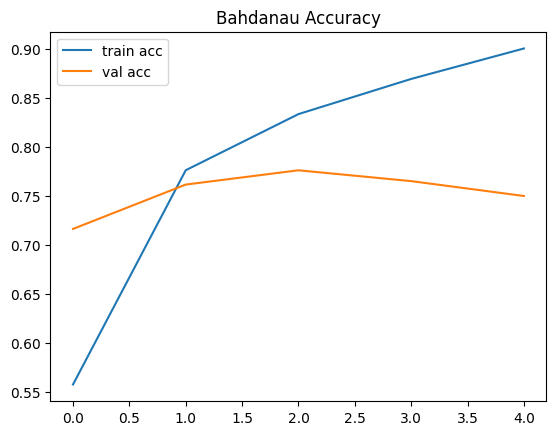

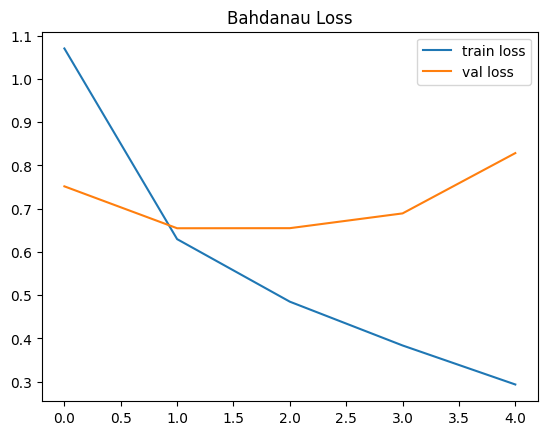

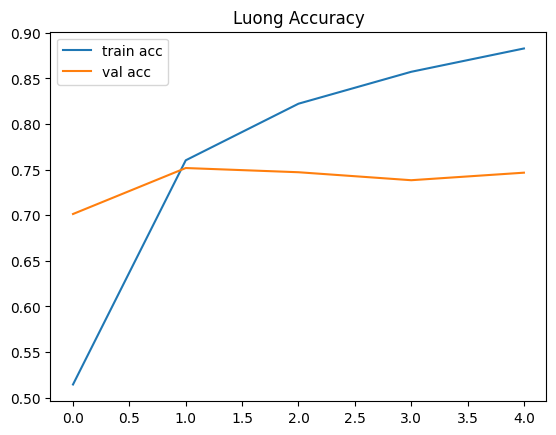

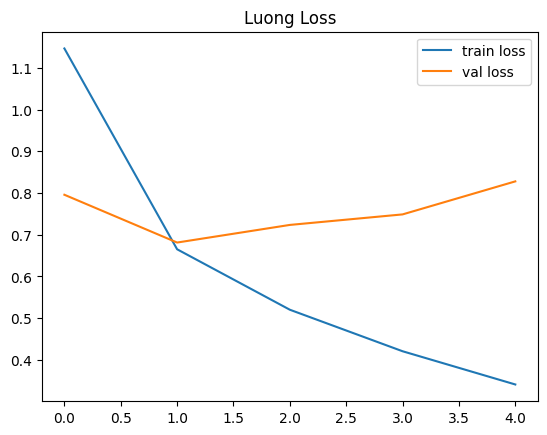

In [145]:
def plot_metrics(history, title):
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.title(f'{title} Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title(f'{title} Loss')
    plt.legend()
    plt.show()

plot_metrics(history_bahdanau, "Bahdanau")
plot_metrics(history_luong, "Luong")


Sample text: trending new yorkers encounter empty supermarket shelves pictured wegmans in brooklyn sold out online grocers foodkick maxdelivery as coronavirus fearing shoppers stock up
Bahdanau Attention:


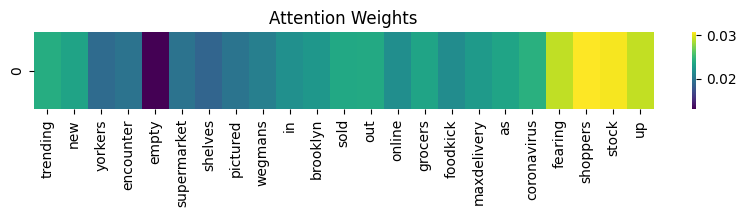

Luong Attention:


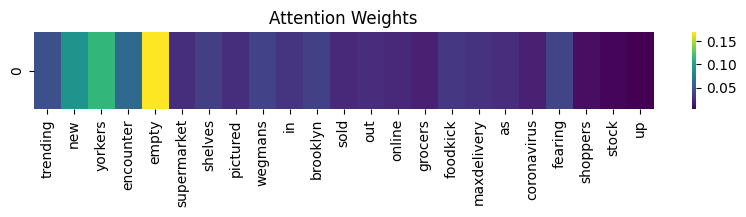

In [146]:
def visualize_attention(model, sample_text, tokenizer, attention_layer):
    sequence = tokenizer.texts_to_sequences([sample_text])
    padded = pad_sequences(sequence, maxlen=max_len, padding='post')
    attention_model = Model(inputs=model.input, outputs=model.layers[-2].output)
    encoder_output = model.layers[1](padded)
    lstm_out, forward_h, _, backward_h, _ = model.layers[2](encoder_output)
    h = tf.concat([forward_h, backward_h], axis=-1)
    context, attn_weights = attention_layer(lstm_out, h)
    attn_weights = attn_weights.numpy().flatten()

    words = sample_text.split()
    plt.figure(figsize=(10, 1))
    sns.heatmap([attn_weights[:len(words)]], xticklabels=words, cmap='viridis')
    plt.title("Attention Weights")
    plt.show()

test_sample = test_df['OriginalTweet'].iloc[0]
print("Sample text:", test_sample)

print("Bahdanau Attention:")
visualize_attention(model_bahdanau, test_sample, tokenizer, BahdanauAttention(64))

print("Luong Attention:")
visualize_attention(model_luong, test_sample, tokenizer, LuongAttention())


**2. Did Attention Weights Provide Useful Interpretability?**
   
**For the attention weights of luong:** the word **'empty'** is crucial to classification.

**For the attention weights of bahdanau:** has a smoother distribution across the words 

 **1. Which Performed Better and Why?**
 
Bahdanau performed slightly better overall:

A little higher accuracy, macro, and weighted F1.

Especially better on the "Positive" and "Negative" classes in terms of F1-score.

Bahdanau uses additive attention, which gives the model more flexibility by learning attention weights using a small feedforward network.

This helps it focus better on varied patterns in text, which can be more useful for sentiment classification where context matters a lot.

**3. Qualitative Differences in What the Models Focus On?**

**Bahdanau:**

Pays attention to broader context.

Helpful in long or complex sentences.

**Luong:**

Focuses more on specific matching words.

Good for shorter texts or where keywords are strong indicators of sentiment.

Might miss out on subtle changes in meaning caused by sentence structure or negations.

